In [19]:
# code to create boxplots
import xarray as xr
import numpy as np

In [2]:
trends = xr.open_dataset('significant_trends.nc')

In [8]:
trends

<xarray.Dataset>
Dimensions:                        (lat: 340, lon: 360)
Coordinates:
  * lat                            (lat) float32 55.03 55.08 ... 71.93 71.97
  * lon                            (lon) float32 -168.0 -167.9 ... -150.1 -150.0
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 ...

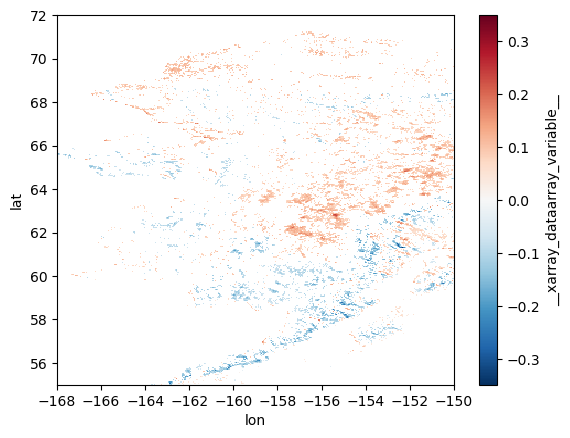

In [18]:
trends['__xarray_dataarray_variable__'].plot()

In [5]:
wetness = xr.open_dataset('../alaska_wt_gradients.nc')

In [11]:
wetness

<xarray.Dataset>
Dimensions:      (x: 3281, y: 1955, band: 1)
Coordinates:
  * x            (x) float64 -171.3 -171.3 -171.3 ... -142.0 -142.0 -142.0
  * y            (y) float64 72.79 72.78 72.77 72.76 ... 55.35 55.34 55.33 55.33
  * band         (band) int64 1
Data variables:
    spatial_ref  int64 ...
    band_data    (band, y, x) float32 ...

In [6]:
# load landcover and anette's landcover! (first normal landcover)
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')

In [7]:
lc = land_cover.sel(lat=slice(72,55), lon=slice(-168,-150))

In [9]:
lc_interp = lc.interp(lat=trends.coords['lat'], lon=trends.coords['lon'], method='nearest')

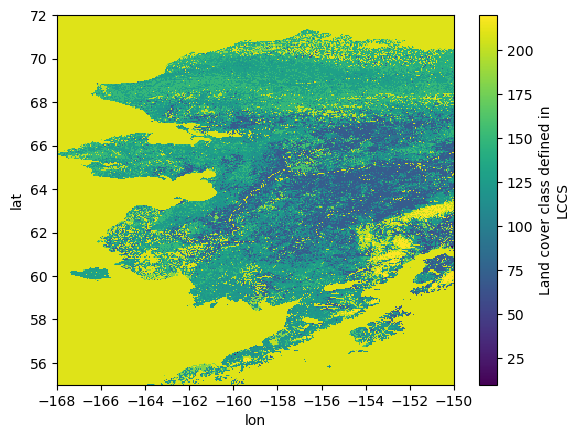

In [16]:
lc_interp['lccs_class'].plot()

In [46]:
lc_interp

<xarray.Dataset>
Dimensions:              (lat: 340, lon: 360)
Coordinates:
  * lat                  (lat) float32 55.03 55.08 55.12 ... 71.88 71.93 71.97
  * lon                  (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.0
Data variables:
    lccs_class           (lat, lon) float32 210.0 210.0 210.0 ... 210.0 210.0
    processed_flag       (lat, lon) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    current_pixel_state  (lat, lon) float32 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    observation_count    (lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    change_count         (lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    crs                  int32 1178880137
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [58]:
wetness_interp = wetness['band_data'].interp(y=trends.coords['lat'], x=trends.coords['lon'], method='nearest').squeeze()

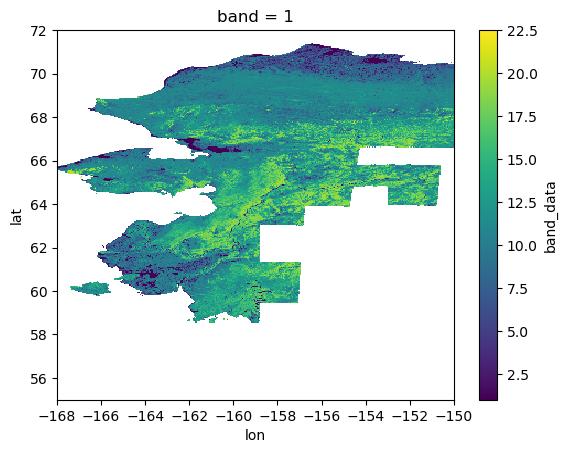

In [83]:
wetness_interp.plot();

In [ ]:
# map the places, where statistical trend exisits !

In [59]:
trend_w = trends.where(~np.isnan(wetness_interp))
wet = wetness_interp.where(~np.isnan(trends['__xarray_dataarray_variable__'])).squeeze()

In [30]:
trend = trends.where(~np.isnan(lc_interp['lccs_class']))
landcover = lc_interp.where(~np.isnan(trends['__xarray_dataarray_variable__']))


In [33]:
landcover

<xarray.Dataset>
Dimensions:              (lat: 340, lon: 360)
Coordinates:
  * lat                  (lat) float32 55.03 55.08 55.12 ... 71.88 71.93 71.97
  * lon                  (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.0
Data variables:
    lccs_class           (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    processed_flag       (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    current_pixel_state  (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    observation_count    (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    change_count         (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    crs                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [34]:
trend_1d = trend['__xarray_dataarray_variable__'].stack(points=("lat", "lon"))
lc_1d = landcover['lccs_class'].stack(points=("lat", "lon"))


In [60]:
trend_1d_w = trend_w['__xarray_dataarray_variable__'].stack(points=("lat", "lon"))
lc_1d_w = wet.stack(points=("lat", "lon"))

In [61]:
valid = (~np.isnan(trend_1d_w)) & (~np.isnan(lc_1d_w))
trend_1d_w = trend_1d_w[valid]
lc_1d_w = lc_1d_w[valid]

In [35]:
valid = (~np.isnan(trend_1d)) & (~np.isnan(lc_1d))
trend_1d = trend_1d[valid]
lc_1d = lc_1d[valid]


In [62]:
import pandas as pd

df_2 = pd.DataFrame({
    "trend": trend_1d_w.values,
    "landcover": lc_1d_w.values.astype(int)
})

In [78]:
# filter classes with very low samples
counts = df_2["landcover"].value_counts()
valid_classes = counts[counts > 10].index

df_2 = df_2[df_2["landcover"].isin(valid_classes)]

In [77]:
counts

landcover
10    712
11    704
12    479
13    456
14    445
15    400
9     337
16    292
17    247
8     230
18    212
7     167
6     126
19    113
5      66
4      41
3      13
2       9
20      8
1       5
Name: count, dtype: int64

In [ ]:


df = pd.DataFrame({
    "trend": trend_1d.values,
    "landcover": lc_1d.values.astype(int)
})


In [39]:
df

,trend,landcover
0,-0.082681,120
1,-0.082299,120
2,-0.085528,180
3,0.074554,120
4,-0.107220,200
...,...,...
10230,0.087044,140
10231,0.087286,150
10232,0.101326,140
10233,0.081949,140


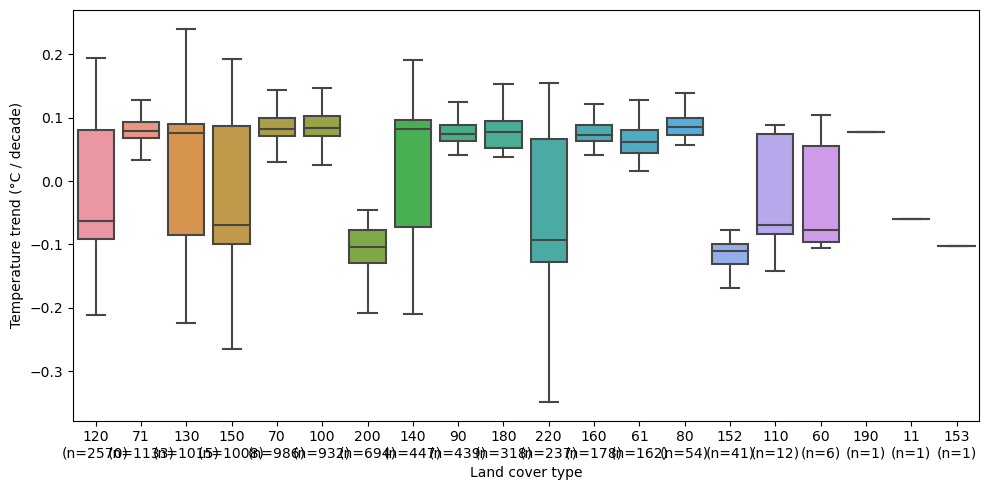

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count samples per class
counts = df["landcover"].value_counts()

# Order classes by appearance or median
order = counts.index

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df,
    x="landcover",
    y="trend",
    order=order,
    showfliers=False
)

# Update x-tick labels to include counts
new_labels = [
    f"{label}\n(n={counts[label]})"
    for label in order
]

ax.set_xticklabels(new_labels)

ax.set_xlabel("Land cover type")
ax.set_ylabel("Temperature trend (°C / decade)")
plt.tight_layout()
plt.show()


In [43]:
# filter classes with very low samples
counts = df["landcover"].value_counts()
valid_classes = counts[counts > 20].index

df = df[df["landcover"].isin(valid_classes)]


In [45]:
counts

landcover
120    2570
71     1133
130    1015
150    1008
70      986
100     932
200     694
140     447
90      439
180     318
220     237
160     178
61      162
80       54
152      41
110      12
60        6
190       1
11        1
153       1
Name: count, dtype: int64

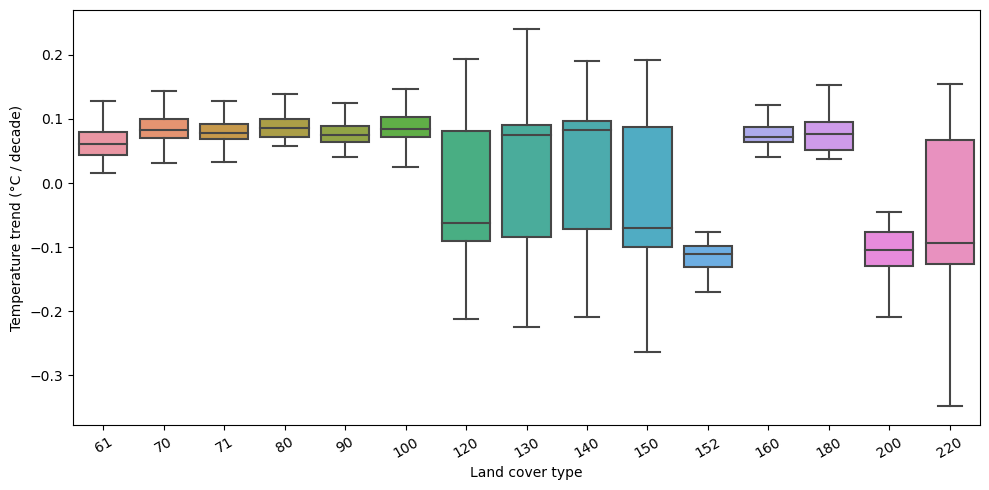

In [ ]:
# merge the classes ! 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="landcover",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 220: permanent snow and ice, 200: bare areas, 180: shrub or herbaceous cover, 160: tree cover, flooded, fresh or brackish water, 152: sparse vegetation, 150:sparse vegetation,
# 140 : liches and moss, 130, grasssland, 120: shrubland, 100: mosaic tree nad shrubs, 90: tree cover, mixed leaves, 80, tree cover decidious, needlleaved, 70, needleaved, evegergren,
# 61 : borad leave deciduous

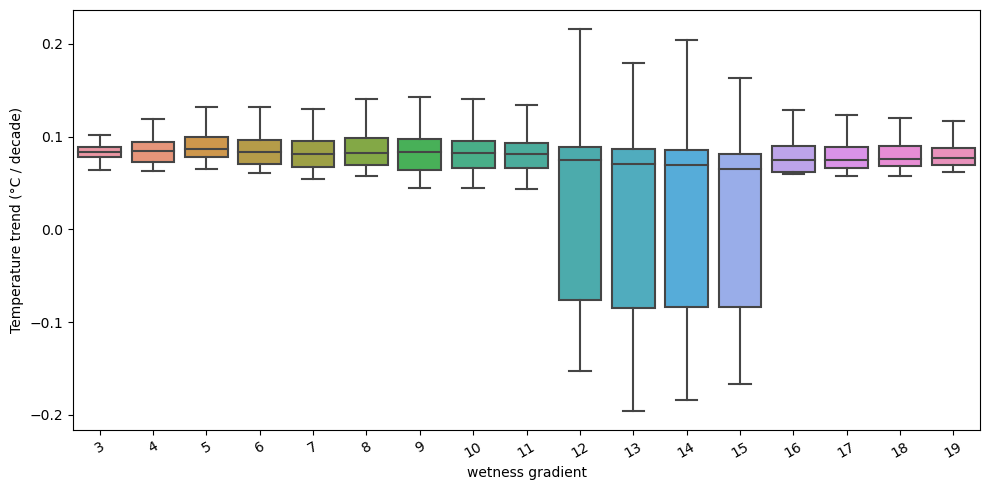

In [ ]:
# verify legends
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_2,
    x="landcover",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("wetness gradient")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# check box plots from Sina -> verify with air temperature !!! -> check "AWI stations"
# 3 wetland, permanent, 4 wet wet to aquatic tundra (seasonal), abundant moss, 5 Moist to wet tundra, abundant moss, prostrate shrubs, 6 dry to moist tundra, partially barren, prostrate shrubs
# 7 dry tundra, abundant lichen, prostrate shrubs, 8 dry to aquatic tundra, dwarf shrubs (& sparse tree cover along treeline), 9 dry to moist tundra, prostrate to low shrubs
# 10 moist tundra, abundant moss, prostrate to low shrubs, 11 moist tundra, abundant moss, dwarf and low shrubs
# different grouping !

In [ ]:
# cluster with reference to air temperature or differences to air temperature ??? 

In [ ]:
# recompute trends for snow cover onset -> or mean values ? yes mean values !
# satellite product ? do like for emissivity ? trends of snow cover ??? -> something more simple !

arclim = xr.open_dataset('../arclim_means.nc')

In [70]:
snow_cover_mean = arclim['SSL']

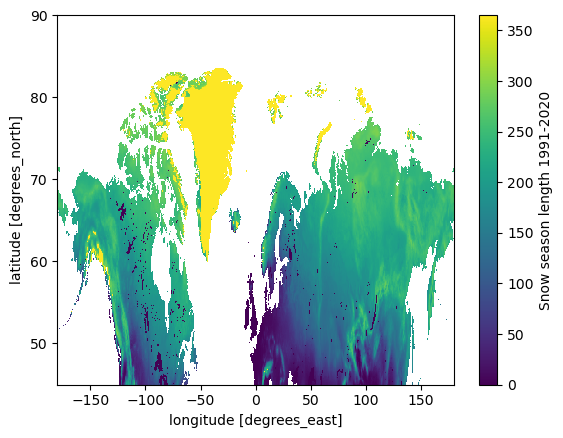

In [ ]:
# extrac areas and interp -> do correlations !
snow_cover_mean.plot();